In [88]:
from keras.layers import Input,Dense,Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
import numpy as np


batch_size=100
original_dim=28*28
latent_dim=2
intermediate_dim=256

nb_epoch=20
epsilon_std=1.0



**Encoder**

In [89]:
x=Input(shape=(original_dim,), name='Input')
h=Dense(intermediate_dim,activation='relu',name='encoding')(x)
z_mean=Dense(latent_dim, name='mean')(h)
z_log_var=Dense(latent_dim,name='log-variance')(h)

**Sampling Function**

In [90]:
def sampling(args):
  z_mean,z_log_var=args
  epsilon=K.random_normal(shape=(batch_size,latent_dim),mean=0.)
  return z_mean + K.exp(z_log_var/2)*epsilon
z=Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])  

**Decoder**

In [91]:
decoder_h=Dense(intermediate_dim,activation='relu',name='decoder_h')(z)
x_decoded=Dense(original_dim,activation='sigmoid',name='flat_decoded')(decoder_h)

**Loss Function**

In [92]:
xent_loss=original_dim * objectives.binary_crossentropy(x,x_decoded)
kl_loss= 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis = -1)
vae_loss=xent_loss + kl_loss

vae = Model(x,x_decoded)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      Input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
______________________________________________________________________________________

**Train/Test Split**

In [93]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)

**Training and Validating**

In [94]:
vae.fit(x_train,shuffle=True,epochs=nb_epoch,batch_size=batch_size,validation_data=(x_test,None),verbose=1)

Epoch 1/20
600/600 [==============================] - 8s 13ms/step - loss: 190.0837 - val_loss: 173.1271
Epoch 2/20
600/600 [==============================] - 7s 12ms/step - loss: 170.3410 - val_loss: 168.1322
Epoch 3/20
600/600 [==============================] - 7s 12ms/step - loss: 166.9641 - val_loss: 165.9086
Epoch 4/20
600/600 [==============================] - 8s 13ms/step - loss: 164.7003 - val_loss: 163.9192
Epoch 5/20
600/600 [==============================] - 7s 12ms/step - loss: 163.0892 - val_loss: 163.0836
Epoch 6/20
600/600 [==============================] - 8s 13ms/step - loss: 161.7581 - val_loss: 161.3759
Epoch 7/20
600/600 [==============================] - 7s 12ms/step - loss: 160.5795 - val_loss: 160.8702
Epoch 8/20
600/600 [==============================] - 7s 12ms/step - loss: 159.4781 - val_loss: 159.4358
Epoch 9/20
600/600 [==============================] - 7s 12ms/step - loss: 158.4796 - val_loss: 158.4416
Epoch 10/20
600/600 [==============================] - 

**Build Encoder**

In [95]:
# build encoder
encoder = Model(x,z_mean)
encoder.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoding (Dense)             (None, 256)               200960    
_________________________________________________________________
mean (Dense)                 (None, 2)                 514       
Total params: 201,474
Trainable params: 201,474
Non-trainable params: 0
_________________________________________________________________


**Plot of digit classes**

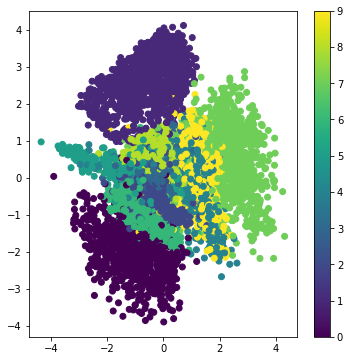

In [98]:
import matplotlib.pyplot as plt

x_te_latent = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_test)
plt.colorbar()
plt.show()